<a href="https://colab.research.google.com/github/derrickny/BI-Project/blob/main/model_and_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install keras_balanced_batch_generator


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Libraries for data preprocessing and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Libraries for working with text data
import gensim
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
# Download NLTK stopwords data
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# Libraries for building and training deep learning models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchtext.data.functional import to_map_style_dataset
from torchmetrics.classification import BinaryF1Score
from torchtext.data.utils import get_tokenizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D, Dropout, Bidirectional
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from keras.utils import to_categorical
from keras.models import load_model
from tensorflow.keras.utils import plot_model

from keras_balanced_batch_generator import make_generator
from sklearn.linear_model import PassiveAggressiveClassifier

# Libraries for model evaluation and metrics
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score,train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix,roc_curve,roc_auc_score


# Miscellaneous libraries
import os
import json
import time
import gc
import random
import warnings
warnings.filterwarnings('ignore')
import re
import string
from typing import Dict
from IPython.display import Image
from collections import Counter

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Load JSON data into a Pandas DataFrame
df= pd.read_json('/content/drive/MyDrive/data/politifact_factcheck_data.json' , lines=True)

df.head(10)


verdict statement_originator  \
0         true         Barack Obama   
1        false           Matt Gaetz   
2  mostly-true         Kelly Ayotte   
3        false             Bloggers   
4    half-true         Bobby Jindal   
5         true            S.E. Cupp   
6        false     Michele Bachmann   
7         true        George Turner   
8  mostly-true          Kent Conrad   
9         true       Mandela Barnes   

                                           statement statement_date  \
0  John McCain opposed bankruptcy protections for...      6/11/2008   
1  "Bennie Thompson actively cheer-led riots in t...       6/7/2022   
2  Says Maggie Hassan was "out of state on 30 day...      5/18/2016   
3  "BUSTED: CDC Inflated COVID Numbers, Accused o...       2/1/2021   
4  "I'm the only (Republican) candidate that has ...      8/30/2015   
5  "There are actually only 30 countries that pra...      8/23/2015   
6  "My husband and I have never gotten a penny of...      6/26/2011   
7  "If you go strictly by the numbers, crime is d...       4/4/2011   
8  "The American people say, don't touch Social S...      1/23/2011   
9  "Since 1978, CEO compensation rose over 1,000%...      5/23/2021   

  statement_source          factchecker factcheck_date  \
0           speech    Adriel Bettelheim      6/16/2008   
1       television          Yacob Reyes      6/13/2022   
2             news       Clay Wirestone      5/27/2016   
3             blog       Madison Czopek       2/5/2021   
4       television            Linda Qiu      8/30/2015   
5             news        Will Cabaniss      8/23/2015   
6             news        Robert Farley       7/1/2011   
7             news   Willoughby Mariano      4/18/2011   
8            other  Angie Drobnic Holan      1/27/2011   
9     social_media        Madeline Heim       6/2/2021   

                             factcheck_analysis_link  
0  https://www.politifact.com/factchecks/2008/jun...  
1  https://www.politifact.com/factchecks/2022/jun...  
2  https://www.politifact.com/factchecks/2016/may...  
3  https://www.politifact.com/factchecks/2021/feb...  
4  https://www.politifact.com/factchecks/2015/aug...  
5  https://www.politifact.com/factchecks/2015/aug...  
6  https://www.politifact.com/factchecks/2011/jul...  
7  https://www.politifact.com/factchecks/2011/apr...  
8  https://www.politifact.com/factchecks/2011/jan...  
9  https://www.politifact.com/factchecks/2021/jun...

In [ ]:

# # Keep only the 'statements' and 'verdict' columns
# df = df[['statement', 'verdict']]

# # Save the DataFrame to a CSV file
# df.to_csv('/content/drive/MyDrive/data/politifact_factcheck_data.csv', index=False)

In [ ]:
# # Map the 'verdict' values to 'true' or 'false'
# verdict_mapping = {
#     'false': 'false',
#     'half-true': 'true',
#     'mostly-false': 'false',
#     'mostly-true': 'true',
#     'pants-fire': 'false',
#     'true': 'true'
# }

# df['verdict'] = df['verdict'].map(verdict_mapping)

# # Save the DataFrame to a CSV file
# df.to_csv('/content/drive/MyDrive/data/politifact_factcheck_data.csv', index=False)

In [ ]:
df.verdict

0                true
1               false
2         mostly-true
3               false
4           half-true
             ...     
21147    mostly-false
21148           false
21149    mostly-false
21150           false
21151    mostly-false
Name: verdict, Length: 21152, dtype: object

In [ ]:
df.info

<bound method DataFrame.info of             verdict statement_originator  \
0              true         Barack Obama   
1             false           Matt Gaetz   
2       mostly-true         Kelly Ayotte   
3             false             Bloggers   
4         half-true         Bobby Jindal   
...             ...                  ...   
21147  mostly-false         Donald Trump   
21148         false     Donald Trump Jr.   
21149  mostly-false          Chris Abele   
21150         false             Bloggers   
21151  mostly-false       Facebook posts   

                                               statement statement_date  \
0      John McCain opposed bankruptcy protections for...      6/11/2008   
1      "Bennie Thompson actively cheer-led riots in t...       6/7/2022   
2      Says Maggie Hassan was "out of state on 30 day...      5/18/2016   
3      "BUSTED: CDC Inflated COVID Numbers, Accused o...       2/1/2021   
4      "I'm the only (Republican) candidate that has ...      8/

In [ ]:
# Check for missing values
print(df.isnull().sum())

verdict                    0
statement_originator       0
statement                  0
statement_date             0
statement_source           0
factchecker                0
factcheck_date             0
factcheck_analysis_link    0
dtype: int64


In [ ]:
df.shape

(21152, 8)

In [ ]:
df.verdict.value_counts()

false           5625
half-true       3597
mostly-false    3432
mostly-true     3332
pants-fire      2703
true            2463
Name: verdict, dtype: int64

In [ ]:
statement_source = df['statement_source'].value_counts()
print(statement_source)

news             5763
social_media     4985
speech           3310
campaign         1230
advertisement    1143
other            1063
blog             1048
television        603
radio             546
statement         515
email             410
meeting           293
testimony         243
Name: statement_source, dtype: int64


In [ ]:
#printing rows of the dataframe
def print_row(input_df:pd.DataFrame,index:int) -> None:
    "relevent columns "
    print(f"speaker: {input_df.iat[index, 1]}")
    print(f"statement_source: {input_df.iat[index, 4]}")
    print(f"statement: {input_df.iat[index, 2]}")
    print(f"label: {input_df.iat[index, 0]}")


In [ ]:
print_row(df,1)

speaker: Matt Gaetz
statement_source: television
statement: "Bennie Thompson actively cheer-led riots in the ’90s."
label: false


In [ ]:
print_row(df,200)

speaker: Steve Lonegan
statement_source: news
statement: "The price tag amounted to nearly $4,200 for every man, woman and child in the state."
label: mostly-false


In [ ]:
statement_source = df['statement_source'].value_counts()
print(statement_source)

news             5763
social_media     4985
speech           3310
campaign         1230
advertisement    1143
other            1063
blog             1048
television        603
radio             546
statement         515
email             410
meeting           293
testimony         243
Name: statement_source, dtype: int64


In [ ]:
print_row(df,634)

speaker: Instagram posts
statement_source: social_media
statement: Transmission of COVID-19 by asymptomatic individuals "has never been proven."
label: false


In [ ]:
print_row(df,900)

speaker: Pam Bondi
statement_source: speech
statement: "By the year 2015 (Medicaid will) take up half our budget."
label: mostly-false


In [ ]:
df.verdict

0                true
1               false
2         mostly-true
3               false
4           half-true
             ...     
21147    mostly-false
21148           false
21149    mostly-false
21150           false
21151    mostly-false
Name: verdict, Length: 21152, dtype: object

### Exploratory Data Analysis(EDA)

In [ ]:
# This function plots a countplot with percentages
def plot_sns_chart(dataframe, y_axis, class_separator=None, width=20.0, height=9.0,
                   font_scale=2, title = 'Title has not been set',
                   xlabel_title="Xlabel title not been set", ylabel_title="Ylabel title not been set",
                   colors=None):
    plt.rcParams['figure.figsize'] = [width, height]
    plt.legend(['Legend'], loc='right')
    sns.set(font_scale=font_scale)
    g = sns.countplot(y=y_axis, hue=class_separator, data=dataframe, palette=colors)
    g.set(xlabel=xlabel_title, ylabel=ylabel_title)
    g.set_title(title)
    total = float(len(dataframe))
    margin = 0.0025
    for patch in g.patches:
        percentage = ' {:.1f}%'.format(100 * patch.get_width() / total)
        x = patch.get_width() + (patch.get_width() * margin)
        y = patch.get_y() + (patch.get_height() / 2)
        g.annotate(percentage, (x, y), va='center')

colors_verdict = {'pants-fire': "#ea5545",
                  'false': "#f46a9b",
                  'mostly-false': "#ef9b20",
                  'half-true': "#edbf33",
                  'mostly-true': "#ede15b",
                  'true': "#bdcf32"
                 }

#### Label Distribution
These definitions were taken from PolitiFact's "truth-o-meter" methodology page

* true – The statement is accurate and there’s nothing significant missing.
* mostly-true – The statement is accurate but needs clarification or additional information.
* half-true – The statement is partially accurate but leaves out important details or takes things out of context.
* barely-true – The statement contains an element of truth but ignores critical facts that would give a different impression.
* false – The statement is not accurate.
* pants-fire – The statement is not accurate and makes a ridiculous claim. a.k.a. "Liar, Liar, Pants on Fire!"

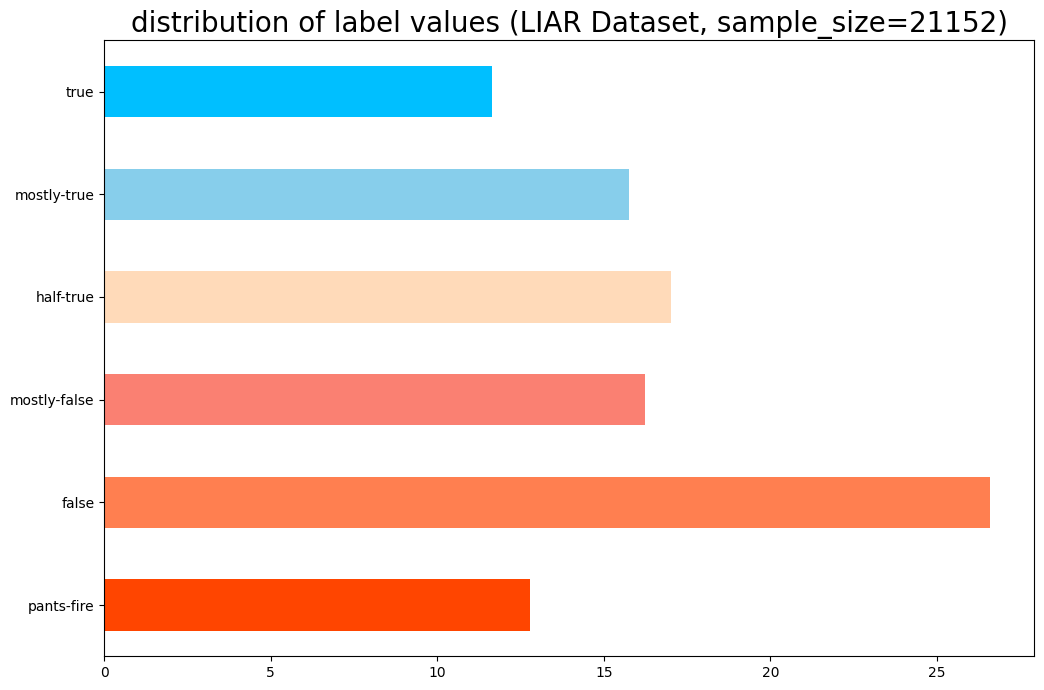

In [ ]:
def label_bar_chart(input_df: pd.DataFrame, title: str = "LIAR Dataset") -> None:

    # computes frequencies of labels and converts to percentages
    label_frequencies = input_df['verdict'].value_counts(normalize=True)

    def multiply_100(x):
        return x * 100

    # "apply" is a handy way to call a function on every row of data.
    label_frequencies = label_frequencies.apply(multiply_100)

    # bar chart ordering and  colors for readability.
    labels = ['pants-fire', 'false', 'mostly-false', 'half-true', 'mostly-true', 'true']
    colors = [
        'orangered', # pants-fire
        'coral', # false
        'salmon', # barely-true
        'peachpuff', # half-true
        'skyblue', # mostly-true
        'deepskyblue' # true
    ]

    label_frequencies = label_frequencies.reindex(index = labels)


    # creates a horizontal bar chart with a descriptive title
    axis = label_frequencies.plot(kind='barh', figsize=(12, 8), color=colors)
    axis.set_title(f"distribution of label values ({title}, sample_size={len(input_df)})", size=20);

label_bar_chart(df)

### Speaker Analysis
Let's take a look at the speaker column now. In order for this data to be super useful, we want a large breadth of speakers. Otherwise, the dataset might be too narrow for general applicability. It might also be nice to look at label distribution for a given speaker.

pandas has a lot of builtin methods to help slice and dice datasets. pandas.Series.nunique() gives us the number of unique values for a column. We can treat pandas.DataFrame like a list and call len(df) to get the total number of rows.

In [ ]:
num_unique_speakers = df['statement_originator'].nunique()
avg_statments = len(df) / num_unique_speakers

print(f"Unique speakers in dataset: {num_unique_speakers}")
print(f"Average statements made per speaker: {avg_statments}")

Unique speakers in dataset: 4565
Average statements made per speaker: 4.633515881708653


In [ ]:
# function to print the top n speakers by number of statements
def speaker_bar_chart(input_df: pd.DataFrame, speaker: str) -> pd.DataFrame:

    # filters the input_df
    speaker_df = input_df[ input_df['statement_originator'] == speaker ]
    speaker_df.reset_index(inplace=True)

    # calls the bar chart function we created earlier
    label_bar_chart(speaker_df, title=speaker)

    return speaker_df

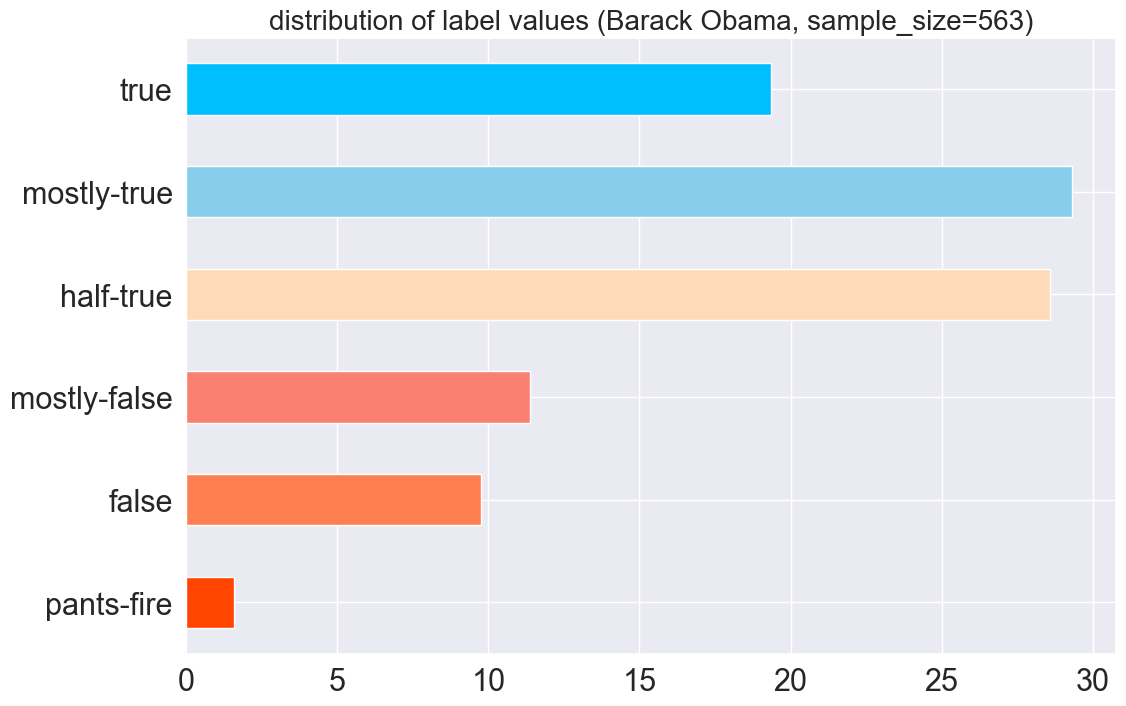

In [ ]:
sp_df = speaker_bar_chart(df, 'Barack Obama')

#### Distribution of verdict

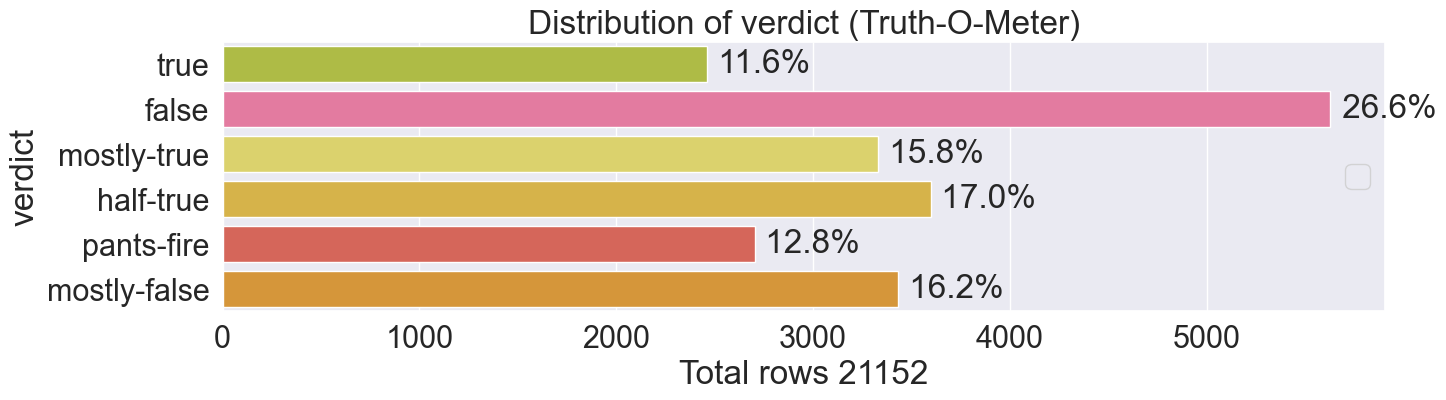

In [ ]:
plot_sns_chart(df, 'verdict', width=15.0, height=3.5,
               title=f'Distribution of verdict (Truth-O-Meter)',
               ylabel_title='verdict',
               xlabel_title=f'Total rows {df.shape[0]}',
               colors=colors_verdict)

The Politifact dataset contains more false statements than other types of verdicts. About 27% of the statements are false and only 11.5% are true. The rest of the statements have some level of either truthness or falseness.

##### **What's the distribution of verdict if we only consider all statements to be either true or false?**

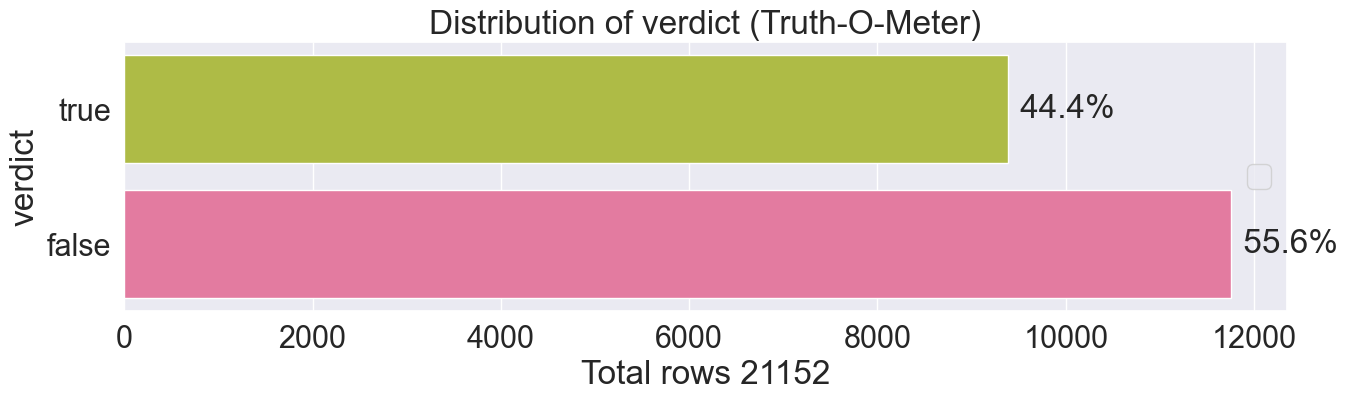

In [ ]:
##What's the distribution of verdict if we only consider all statements to be either true or false?
ver_df = df['verdict'].replace(['pants-fire', 'false', 'mostly-false'], 'false')
ver_df = ver_df.replace(['half-true', 'mostly-true', 'true'], 'true')

#add column name to the series
ver_df = ver_df.to_frame(name='verdict')
plot_sns_chart(ver_df, 'verdict', width=15.0, height=3.5,
                title=f'Distribution of verdict (Truth-O-Meter)',
                ylabel_title='verdict',
                xlabel_title=f'Total rows {df.shape[0]}',
                colors=colors_verdict)

The plot above tells us that this dataset contains more false statements (55.6%). However, the daset also contains 44% of true statements (about 9% difference with false statements).

##### **What are the sources of the statements**

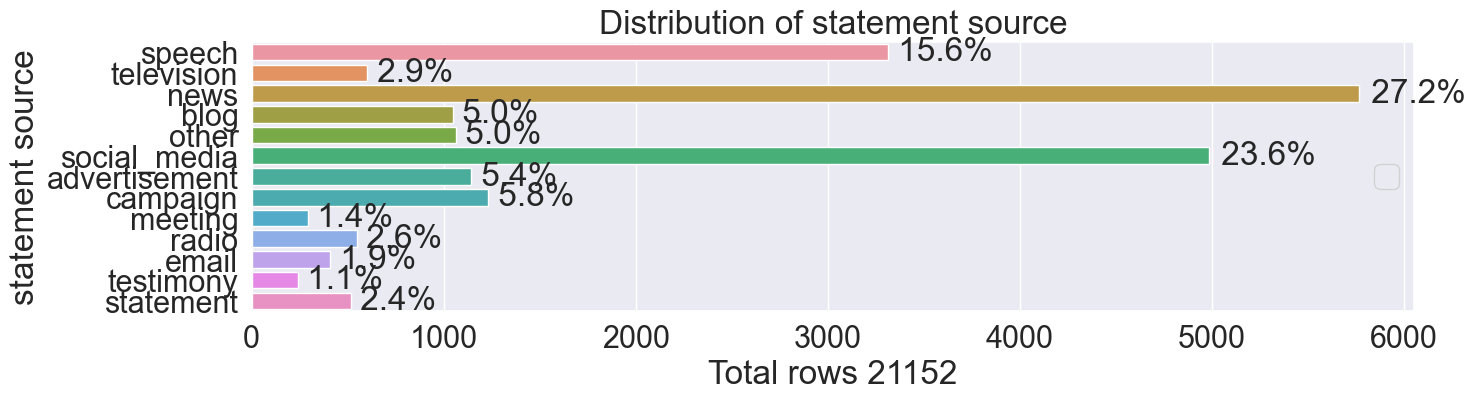

In [ ]:
# What are the source of the statements?
plot_sns_chart(df, 'statement_source', width=15.0, height=3.5,
                title=f'Distribution of statement source',
                ylabel_title='statement source',
                xlabel_title=f'Total rows {df.shape[0]}')

Most of the statements come from either news (27.2%), social media (23.6%), or speech (15.6%). The rest of the statements come from various sources such as blog posts, campaigns, and advertisements, among others.

##### **Whats the relation between statement source and statement**

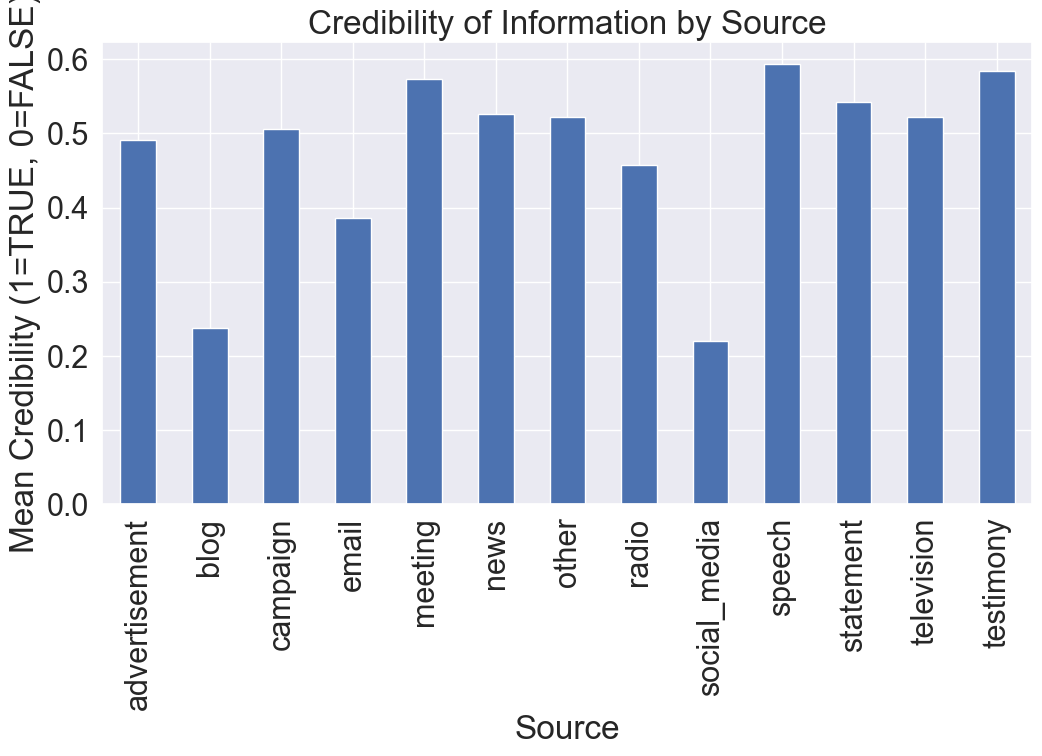

In [ ]:
binary_map = {
    'true': 1,
    'mostly-true': 1,
    'half-true': 1,
    'mostly-false': 0,
    'false': 0,
    'pants-fire': 0
}
df['binary_verdict'] = df['verdict'].map(binary_map)

# Group by statement source and calculate the mean of binary_verdict
source_credibility = df.groupby('statement_source')['binary_verdict'].mean()

# Plot the results
plt.figure(figsize=(12, 6))
source_credibility.plot(kind='bar')
plt.title("Credibility of Information by Source")
plt.xlabel("Source")
plt.ylabel("Mean Credibility (1=TRUE, 0=FALSE)")
plt.xticks(rotation=90)
plt.show()

In [ ]:
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(df['statement_source'], df['binary_verdict'])

# Perform the chi-squared test
chi2, p, _, _ = chi2_contingency(contingency_table)

print("Chi-squared test result:")
print(f"Chi-squared value: {chi2}")
print(f"P-value: {p}")


Chi-squared test result:
Chi-squared value: 1785.0264318255834
P-value: 0.0


The results of the chi-squared test indicate a very low p-value (approximately 0.0), which means that there is a highly significant association between the statement source and the credibility (true or false verdict). This suggests that the statement source is a significant factor in determining the credibility of the statements.

#### What are the lengths for the various statements?

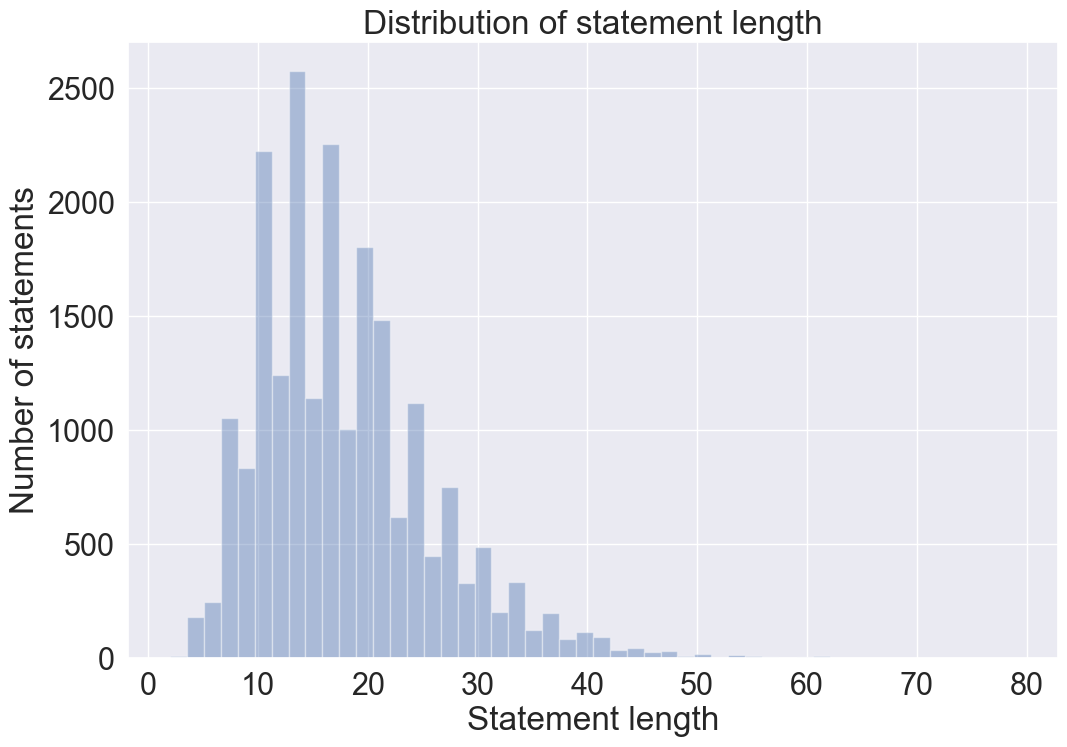

In [ ]:
# Statement length¶
# Now, we turn our attention to the statement column (text) that has the actual statement that was submitted to Politifact for fact-checking:
# Let's see the distribution of the length of the statements
df['statement_length'] = df['statement'].apply(lambda x: len(x.split()))
df['statement_length'].describe()
# plot a histogram to see the distribution of the length of the statements
plt.figure(figsize=(12, 8))
sns.distplot(df['statement_length'], kde=False)
plt.title('Distribution of statement length')
plt.xlabel('Statement length')
plt.ylabel('Number of statements')
plt.show()

As per the Distribution we see that most of the statements lengths are between 10-20

## Modelling

In [ ]:

# Keep only the 'statements' and 'verdict' columns this are te columns that i need for modelling
df = df[['statement', 'verdict']]

# Save the DataFrame to a CSV file
df.to_csv('/content/drive/MyDrive/data/politifact_factcheck_data.csv', index=False)

In [ ]:
# # Map the 'verdict' values to 'true' or 'false'
verdict_mapping = {
    'false': 'false',
    'half-true': 'true',
    'mostly-false': 'false',
    'mostly-true': 'true',
    'pants-fire': 'false',
    'true': 'true'
}

df['verdict'] = df['verdict'].map(verdict_mapping)

# Save the DataFrame to a CSV file
df.to_csv('/content/drive/MyDrive/data/politifact_factcheck_data.csv', index=False)

In [ ]:
df.head()

statement verdict
0  John McCain opposed bankruptcy protections for...    true
1  "Bennie Thompson actively cheer-led riots in t...   false
2  Says Maggie Hassan was "out of state on 30 day...    true
3  "BUSTED: CDC Inflated COVID Numbers, Accused o...   false
4  "I'm the only (Republican) candidate that has ...    true

In [ ]:
##Naive Bayes
# Binarize the labels
binary_map = {
    'true': 1,
    'false': 0,
}
# 1. Preprocess the Data
X = df['statement']
y = df['verdict']

# 2. Vectorize Text Data
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features as needed
X_tfidf = tfidf_vectorizer.fit_transform(X)

# 3. Split the Dataset
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

# 4. Train a Naive Bayes Classifier
naive_bayes_classifier = MultinomialNB()
naive_bayes_classifier.fit(X_train, y_train)

# 5. Make Predictions
y_pred = naive_bayes_classifier.predict(X_test)

# 6. Evaluate the Model
report = classification_report(y_test, y_pred)
print(report)



              precision    recall  f1-score   support

       false       0.69      0.70      0.70      2352
        true       0.62      0.61      0.62      1879

    accuracy                           0.66      4231
   macro avg       0.66      0.66      0.66      4231
weighted avg       0.66      0.66      0.66      4231



In [167]:
#Cleaning statements

def clean_text(text):
    '''Make text lowercase, remove punctuation and remove words containing numbers.'''
    text = text.lower()
    text = re.sub('.*?¿', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('[0-9]+', '', text)
    text = re.sub(r" +", " ", text)
    return text

def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = [word for word in word_tokens if word.lower() not in stop_words]
    return " ".join(filtered_text)

def remove_spaces(text):
    text = re.sub(r" +", " ", text)
    return text

In [168]:
#cleaning statement
df['cleaned_statement'] = df['statement'].apply(clean_text)
df['cleaned_statement'] = df['cleaned_statement'].apply(remove_stop_words)
df['cleaned_statement'] = df['cleaned_statement'].apply(remove_spaces)

In [169]:
class PolitifactDataset(Dataset):
    def __init__(self, text1, labels):
        self.text1 = text1.values

        self.labels = labels.values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        text1 = self.text1[idx]
        sample = (label, text1)
        return sample


In [170]:
dataset = PolitifactDataset(df["cleaned_statement"], df["verdict"])


In [171]:
print('\nFirst element of dataset: ', next(iter(dataset)), '\n')
print('Length of dataset: ', len(dataset), '\n')


First element of dataset:  ('true', 'john mccain opposed bankruptcy protections families bankruptcy medical expenses couldnt pay') 

Length of dataset:  21152 



### Logistic Regression

In [ ]:
# Define your features and target variable
X = df['cleaned_statement']
y = df['verdict']  # The target variable (labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a CountVectorizer to convert text data to numerical features
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Create and train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display a classification report with more detailed metrics
print(classification_report(y_test, y_pred))

Accuracy: 0.65
              precision    recall  f1-score   support

       false       0.68      0.70      0.69      2352
        true       0.61      0.58      0.59      1879

    accuracy                           0.65      4231
   macro avg       0.64      0.64      0.64      4231
weighted avg       0.64      0.65      0.65      4231



### SVM

In [ ]:
from sklearn.svm import SVC

# Define your features and target variable
X = df['statement']
y = df['verdict']  # The target variable (labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a CountVectorizer to convert text data to numerical features
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Create and train an SVM classifier (you can choose a different kernel if needed)
model = SVC(kernel='linear', C=1.0)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display a classification report with more detailed metrics
print(classification_report(y_test, y_pred))

Accuracy: 0.64
              precision    recall  f1-score   support

       false       0.68      0.66      0.67      2352
        true       0.59      0.61      0.60      1879

    accuracy                           0.64      4231
   macro avg       0.63      0.63      0.63      4231
weighted avg       0.64      0.64      0.64      4231



### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
# Define your features and target variable
X = df['statement'] # Combine statement and statement_source
y = df['verdict']  # The target variable (labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a CountVectorizer to convert text data to numerical features
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Create and train a KNN classifier
model = KNeighborsClassifier(n_neighbors=15)  # You can adjust the number of neighbors
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display a classification report with more detailed metrics
print(classification_report(y_test, y_pred))

Accuracy: 0.62
              precision    recall  f1-score   support

       false       0.62      0.79      0.70      2352
        true       0.61      0.40      0.48      1879

    accuracy                           0.62      4231
   macro avg       0.61      0.60      0.59      4231
weighted avg       0.61      0.62      0.60      4231



### Logestic Regression and SVM Ensemble

In [172]:
from sklearn.ensemble import VotingClassifier
# Define your features and target variable
X = df['cleaned_statement']
y = df['verdict']  # The target variable (labels)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a CountVectorizer to convert text data to numerical features
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Create individual models
logistic_model = LogisticRegression(max_iter=1000)
svm_model = SVC(probability=True)

# Create a voting classifier
voting_classifier = VotingClassifier(estimators=[('logistic', logistic_model), ('svm', svm_model)], voting='soft', n_jobs=-1)


# Fit the ensemble model to your data
voting_classifier.fit(X_train, y_train)

# Make predictions
y_pred = voting_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Ensemble Model Accuracy: {accuracy:.2f}")

# Display a classification report with more detailed metrics
print(classification_report(y_test, y_pred))

Ensemble Model Accuracy: 0.66
              precision    recall  f1-score   support

       false       0.68      0.72      0.70      2352
        true       0.62      0.58      0.60      1879

    accuracy                           0.66      4231
   macro avg       0.65      0.65      0.65      4231
weighted avg       0.65      0.66      0.65      4231



### Logestic Regression, Random Forest and SVM Ensemble

In [ ]:
# Define your features and target variable
X = df['cleaned_statement']
y = df['verdict']  # The target variable (labels)

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a CountVectorizer to convert text data to numerical features
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

# Define and train your individual models with optimal hyperparameters
svm = SVC(kernel='linear', C=1.0, probability=True)
logistic_regression = LogisticRegression(C=1.0, penalty='l2', max_iter=1000)
random_forest = RandomForestClassifier(n_estimators=100, max_depth=10)

# Create the ensemble model using majority voting
ensemble = VotingClassifier(estimators=[
    ('svm', svm),
    ('logistic_regression', logistic_regression),
    ('random_forest', random_forest)
], voting='soft')  # 'soft' for probability-based voting

# Train the ensemble model on the training data
ensemble.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ensemble.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Ensemble Accuracy: {accuracy:.2f}")

Ensemble Accuracy: 0.65


In [ ]:


# Assuming df contains your DataFrame
X = df['cleaned_statement']
y = df['verdict']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a CountVectorizer to convert text data to numerical features
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)


In [ ]:
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.toarray(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.toarray(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# Create DataLoader for training and testing
train_dataset = TextDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataset = TextDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Model hyperparameters
input_size = X_train.shape[1]  # Number of features
hidden_size = 128  # Number of neurons in the hidden layer
num_classes = 2  # Number of classes (binary classification)

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out




In [ ]:
# Create the neural network model
model = NeuralNetwork(input_size, hidden_size, num_classes)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    # Calculate accuracy on the test set
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}, Test Accuracy: {accuracy:.2f}%')

Epoch [1/10], Loss: 0.5283, Test Accuracy: 66.04%
Epoch [2/10], Loss: 0.5278, Test Accuracy: 65.45%
Epoch [3/10], Loss: 0.5800, Test Accuracy: 64.12%
Epoch [4/10], Loss: 0.3742, Test Accuracy: 63.86%
Epoch [5/10], Loss: 0.1973, Test Accuracy: 64.36%
Epoch [6/10], Loss: 0.0999, Test Accuracy: 63.77%
Epoch [7/10], Loss: 0.0576, Test Accuracy: 64.41%
Epoch [8/10], Loss: 0.0604, Test Accuracy: 63.65%
Epoch [9/10], Loss: 0.0139, Test Accuracy: 63.48%
Epoch [10/10], Loss: 0.0217, Test Accuracy: 63.67%


In [ ]:
#A passive aggressive classifier
X = df['cleaned_statement']
y = df['binary_verdict']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [ ]:
# Create and train the Passive Aggressive Classifier
pac = PassiveAggressiveClassifier(max_iter=1000)
pac.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred = pac.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display a classification report with more detailed metrics
print(classification_report(y_test, y_pred))

Accuracy: 0.61
              precision    recall  f1-score   support

           0       0.64      0.66      0.65      2352
           1       0.56      0.54      0.55      1879

    accuracy                           0.61      4231
   macro avg       0.60      0.60      0.60      4231
weighted avg       0.60      0.61      0.60      4231



After training the model using a variety of algorithms, I found that the accuracy was consistently in the range of 61-65%. Recognizing the potential for further improvement, I decided to shift the focus exclusively to Natural Language Processing (NLP) algorithms. In this pursuit, I explored the application of GloVe, an impactful NLP technique.

GloVe, or Global Vectors for Word Representation, is built on a fundamental idea—deriving semantic relationships between words from a co-occurrence matrix. This matrix captures how often words appear together in a given corpus. By considering the probability of two words co-occurring relative to a third word, GloVe effectively measures semantic similarity.

In essence, the behavior of P_ik/P_jk, where P_ik represents the probability of words i and k appearing together, offers insights into the semantic relationships within the corpus. If a 'probe word' k is similar to one word (e.g., ice) but unrelated to another (e.g., steam), P_ik/P_jk will be high for the former and low for the latter. This method allows us to incorporate global statistics when learning word vectors.

 By leveraging GloVe in our NLP model, we aim to enhance the semantic understanding of our data, potentially leading to a more accurate and nuanced representation of language. This strategic shift reflects a commitment to harnessing the power of specialized NLP techniques to achieve a higher level of model performance and accuracy.

### Find the implementation of GloVe in the next notebook NLP.ipynb